In [1]:
import numpy as np
import scipy.signal
from scipy.optimize import minimize
import pandas as pd
pd.set_option('max_columns', None)
from sklearn import linear_model
import matplotlib.pyplot as plt
from datetime import datetime
plt.rcParams['figure.figsize'] = [15, 7.5]
plt.rcParams.update({'font.size': 16,'legend.fontsize':16})
import seaborn as sns
import sys
import os
import fur.path_assistant as path_assistant
from fur.waveform_reader import read_waveform
from fur.finding_period import get_period
from fur.fluctuations import get_fluctiation_and_noise_var
from fur.one_data_set_analyzer import analyze_one_dataset
from fur.extending_with_acnet_data import get_fluctuations_df_with_acnet_data, get_acnet_df_with_bunch_sizes
shift = path_assistant.PathAssistant('shift_03_16_2020',
    ignore_files=['RefCurve_2020-03-16_0_084020_test.Wfm.bin',
                  'RefCurve_2020-03-16_153_155200.Wfm.bin'])
#shift_03_09_2020.show_waveform_file_names()
waveforms_dir = shift.get_waveforms_dir()
results_dir = shift.get_results_dir()
from config import get_from_config, save_to_config
from wiggler_radiation.number_of_coherent_modes.coherent_modes import get_M_interpolator_at_fixed_energy
import lattice.lattice as lattice
from lattice.summary_in_undulator import CalcTransverseBeamParams
from wiggler_radiation.Wigrad.wigrad_generator import \
    generate_wr_sim_with_wigrad_results_and_spectral_transmission
import coherent_modes_cpp as cm

In [2]:
cur_to_sum_channel = get_from_config("Beam_current_to_Sum_channel_ampl_V/mA")
sum_channel_to_photoelectrons =\
    get_from_config('sum_channel_to_photoelectrons')
meas_photons_per_electron =\
    get_from_config("Measured_photons_per_electron")
meas_photons_per_electron

0.008820875499988542

In [3]:
from scipy.interpolate import interp1d
bp_df = pd.read_csv(
    shift.get_results_dir().fi("beam_params_vs_current_round.csv"))
sx_func = interp1d(bp_df["N"], bp_df['Sigma_um_X'],
                   bounds_error=False, fill_value="extrapolate")
sy_func = interp1d(bp_df["N"], bp_df['Sigma_um_Y'],
                   bounds_error=False, fill_value="extrapolate")
sz_func = interp1d(bp_df["N"], bp_df['sz_um'],
                   bounds_error=False, fill_value="extrapolate")
ex_func = interp1d(bp_df["N"], bp_df['ex_um'],
                   bounds_error=False, fill_value="extrapolate")
ey_func = interp1d(bp_df["N"], bp_df['ey_um'],
                   bounds_error=False, fill_value="extrapolate")
dpp_func = interp1d(bp_df["N"], bp_df['dp/p'],
                    bounds_error=False, fill_value="extrapolate")

In [4]:
Ibeam = get_from_config("NominalBeamCurrent_mA")
N_to_I = 1/sum_channel_to_photoelectrons/cur_to_sum_channel

In [5]:
m0 = 10000
mfold = 8
seed = 1

In [6]:
lattice_df = \
    lattice.read_lattice_file(shift.get_6dsim_dir()\
    .fi("IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt"))

In [7]:
N0s = np.linspace(0.7e7, 2.25e7, 3)
df_to_save = pd.DataFrame({"N": np.concatenate([[0], N0s])})

In [8]:
Ebeam0 = get_from_config("gamma")*0.511
Ebeam_error = get_from_config("Ebeam_error_MeV")
Ku0 = get_from_config("K_peak")
Ku_error = get_from_config("Ku_error")

In [9]:
EK_list = [
    [Ebeam0, Ku0, 'Middle'],
    [Ebeam0-Ebeam_error, Ku0, 'Middle'],
    [Ebeam0+Ebeam_error, Ku0, 'Middle']]

In [10]:
for j,EKpos in enumerate(EK_list):
    E_in, K_peak_in, where_in_und = EKpos
    gamma_in = E_in/0.511
    print(f"Working on EK {j+1} out of {len(EK_list)}")
    wr_sim, spect = generate_wr_sim_with_wigrad_results_and_spectral_transmission(
    K_peak_in=K_peak_in,
    gamma_in=gamma_in)
    ampx3d = wr_sim.get_amplittude_3D(polarization='x')
    mesh = get_from_config("radiation_mesh")
    zobs = get_from_config("z_obs_m")
    xmin, xmax, _ = mesh[0]
    xmin = xmin/zobs
    xmax = xmax/zobs
    ymin, ymax, _ = mesh[1]
    ymin = ymin/zobs
    ymax = ymax/zobs
    lmin, lmax, _ = mesh[2]
    dax = (xmax-xmin)/(mesh[0][2]-1)
    day = (ymax-ymin)/(mesh[1][2]-1)
    dl = (lmax-lmin)/(mesh[2][2]-1)
    elliptic_aperture = \
        (wr_sim.x_3D**2/xmax**2+wr_sim.y_3D**2/ymax**2) < 1
    sm =dax*day*dl*np.sum(
        spect[:,None,None]*np.absolute(ampx3d*elliptic_aperture)**2)
    Ms = np.zeros(N0s.shape)
    for i,N0 in enumerate(N0s):
        print(f"Working on {i+1} out of {len(N0s)}")
        ex = ex_func(N0)
        ey = ey_func(N0)
        dpp = dpp_func(N0)
        st = sz_func(N0)
        # here ypu can adjust emittances to see how the result changes
        adj = 1.0
        Sx, Sy, dx, dy, sxp, syp = CalcTransverseBeamParams(
            lattice_df,adj*ex,adj*ey,dpp,where_in_und)
        # Sx, Sy, dx, dy, sxp, syp = sx, sy, 0, 0, 0, 0
        coh_modes_cpp_args =  np.asarray([Sx,Sy,dx,dy,sxp,syp,xmin,xmax,ymin,ymax,lmin,lmax,
                                          st, sm, m0,mfold,seed],
                                        dtype=np.float64)
        Ms[i] = np.real(
            cm.CalcMFromPrecalculatedFieldAmps(ampx3d,spect,coh_modes_cpp_args)[-1])
    df_to_save[f"{E_in},{K_peak_in},{where_in_und}"] = np.concatenate([[0], N0s+N0s**2/Ms])
df_to_save.to_csv("theor_NvarN.csv")

Working on EK 1 out of 3
Working on 1 out of 3
Working on 2 out of 3
Working on 3 out of 3
Working on EK 2 out of 3
Working on 1 out of 3
Working on 2 out of 3
Working on 3 out of 3
Working on EK 3 out of 3
Working on 1 out of 3
Working on 2 out of 3
Working on 3 out of 3


In [11]:
nvarn_df = pd.read_csv("theor_NvarN.csv", index_col=0)

In [12]:
nvarn_df

,N,"96.400000000038,1.0,Middle","95.400000000038,1.0,Middle","97.400000000038,1.0,Middle"
0,0.0,0.000000e+00,0.000000e+00,0.000000e+00
1,7000000.0,2.500810e+07,2.707100e+07,2.304604e+07
2,14750000.0,7.292941e+07,7.959189e+07,6.660948e+07
3,22500000.0,1.323115e+08,1.449028e+08,1.203869e+08


In [13]:
Ns = nvarn_df['N']
varN0 = nvarn_df.iloc[:,1]
EerrT = nvarn_df.iloc[:,2]-varN0
EerrB = varN0-nvarn_df.iloc[:,3]
KerrT = 0
KerrB = 0
PerrB = 0
PerrT = 0 # both ends of the undulator are Bottom
errT = np.sqrt(EerrT**2+KerrT**2+PerrT**2)
errB = np.sqrt(EerrB**2+KerrB**2+PerrB**2)
varNT = varN0+errT
varNB = varN0-errB
varN0func = interp1d(Ns, varN0,
                   bounds_error=False, fill_value="extrapolate", kind="cubic")
varNTfunc = interp1d(Ns, varNT,
                   bounds_error=False, fill_value="extrapolate", kind="cubic")
varNBfunc = interp1d(Ns, varNB,
                   bounds_error=False, fill_value="extrapolate", kind="cubic")
pd.DataFrame({"EerrB":EerrB, "KerrB":KerrB, "PerrB":PerrB})

,EerrB,KerrB,PerrB
0,0.000000e+00,0,0
1,1.962058e+06,0,0
2,6.319925e+06,0,0
3,1.192460e+07,0,0


In [14]:
x = np.linspace(0,2.25e7,50)
theor_df = pd.DataFrame({"N": x})
theor_df["varN"] = varN0func(x)
theor_df['varN_bottom'] = varNBfunc(x)
theor_df['varN_top'] = varNTfunc(x)

In [15]:
Cferr = 0.0
cf = 1+Cferr

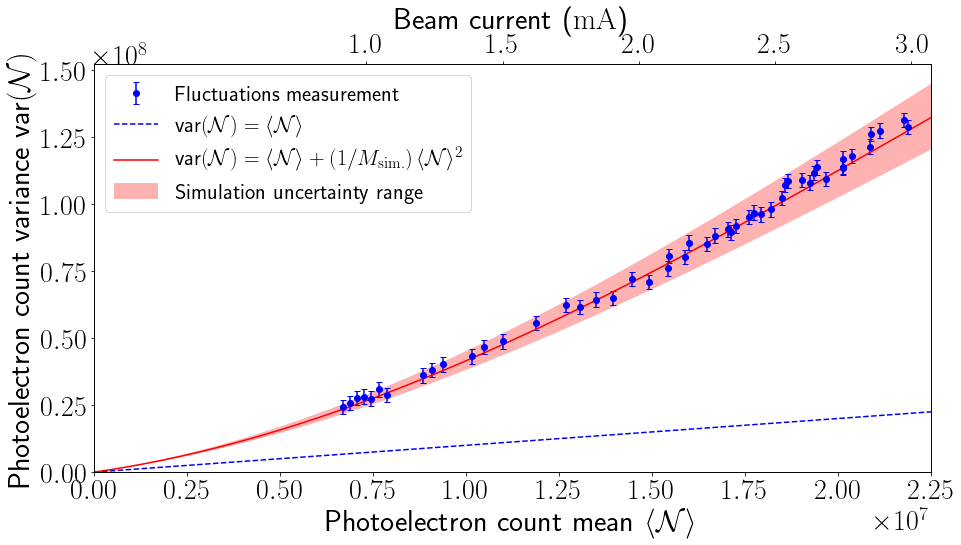

In [16]:
hybrid_balance_error = get_from_config("HybridBalanceError")
fit_errorbar = get_from_config("varN_error_fit")
plt.rcParams["text.usetex"] =True
plt.rc('text.latex', preamble=r'\usepackage{siunitx}')
plt.rcParams.update({'font.size': 28,
                     'legend.fontsize':22,
                     'errorbar.capsize':3})
fig, ax = plt.subplots(figsize=(15, 7.5))
res_df_loaded = \
    pd.read_csv(shift.get_results_dir().fi('meas_ROUND_03_16_2020.csv'),
                index_col=0)
res_df_ROUND_no_outliers = res_df_loaded
hybrid_errorbar = 2*hybrid_balance_error\
    *np.absolute(res_df_ROUND_no_outliers['varN'])
error_bar = np.sqrt(0*hybrid_errorbar**2+fit_errorbar**2)
res_df_ROUND_no_outliers['errorbar'] = error_bar
ax.errorbar(cf*res_df_ROUND_no_outliers['N'],cf**2*res_df_ROUND_no_outliers['varN'],
            marker='o',linestyle='None',yerr=error_bar,color='b',
            label = r'Fluctuations measurement')
x_aux = np.linspace(0, theor_df['N'].values[-1], 100)
ax.set_xlim(0, x_aux[-1])
ax.plot(x_aux, x_aux,color='blue',linestyle='--',
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}\rangle$")
ax.plot(theor_df['N'], theor_df['varN'], color='red',
        label = r"var$\left(\mathcal{N}\right)=\langle\mathcal{N}"
        r"\rangle+\left(1/M_{\mathrm{sim.}}\right)\langle\mathcal{N}\rangle^2$")
ax.fill_between(
    theor_df['N'],
    theor_df['varN_bottom'],
    theor_df['varN_top'],
    facecolor='red', alpha=0.3,
    label="Simulation uncertainty range")

ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, ax.get_ylim()[1])

ax.set_ylabel(r"Photoelectron count variance var$\left(\mathcal{N}\right)$")
ax.set_xlabel(r"Photoelectron count mean $\langle\mathcal{N}\rangle$")
# ax.set_title(r"Round beam, no ND filters, variable beam current")
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,0,1,2]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
ax1 = ax.twiny()
ax1.set_xlabel(r"Beam current (\SI{}{mA})")
ax1.set_xlim(N_to_I*np.asarray(ax.get_xlim()))
# xlim_max = theor_df['N'].values[-1]
# ax.set_xlim(0,xlim_max)
# ax1.set_xlim(0,xlim_max)
ax1.set_xticks(ticks=ax1.get_xticks()[2:-1])
plt.savefig(shift.get_results_dir().fi("round_beam.png"),
            dpi=300, bbox_inches='tight')
plt.show()

# Calculation of M for Gaussian light beam model

## The experimental point is chosen here (`pt_idx`)

In [17]:
res_df_ROUND = get_fluctuations_df_with_acnet_data(
    shift,
    "res_df_comb_filter_no_nd_filters_ROUND_data_03_16_2020.csv",
    "IOTA_1NL_100MeV_v8.6.1.4.6ds_data.txt",
    'all_acnet_data_ROUND_case_03_16_2020.csv',
    show_plot=False
)

/home/ilobach/fur/env/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/ilobach/fur/lattice/lattice.py:160: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(e_um*1e4*beta_cm+(1e4*dispersion_cm*dpp)**2)


In [18]:
pt_idx = 0
emittance_6D = {}
for key in ['ex_um', 'ex_err', 'ey_um', 'ey_err', 'dp/p', 'dp/p_err']:
    emittance_6D[key] = res_df_ROUND.loc[pt_idx, key]
ex = emittance_6D['ex_um']
ey = emittance_6D['ey_um']
dpp = emittance_6D['dp/p']
st = res_df_ROUND.loc[pt_idx, 'N:IWCMBE']*1e4 #microns
Sx, Sy, dx, dy, sxp, syp = CalcTransverseBeamParams(lattice_df,ex,ey,dpp)
Sx, Sy, dx, dy, sxp, syp, st

(300.33433249026905,
 240.67384278137428,
 1049954.5663612229,
 -487663.40045622655,
 0.0004339331418031466,
 0.00043148229886993364,
 286275.88162576384)

## Gaussian light beam and nonzero electorn beam divergence

In [19]:
lmda = 1.097
k0 = 2*np.pi/lmda
Nu=10.5
usw = k0/Nu

In [20]:
gamma = get_from_config("gamma")

In [21]:
usxp = usyp = 1/np.sqrt(Nu)/gamma
usxp

0.0016358716147426948

In [22]:
# the Gaussian light beam approximation with electron beam divergence
M_Gauss_with_beam_div=\
    np.sqrt(1+4*usw**2*st**2)\
    *np.sqrt(1+4*k0**2*Sx**2*usxp**2+sxp**2*(4*k0**2*(usxp**2*dx**2+Sx**2)+1/usxp**2))\
    *np.sqrt(1+4*k0**2*Sy**2*usyp**2+syp**2*(4*k0**2*(usyp**2*dy**2+Sy**2)+1/usyp**2))
M_Gauss_with_beam_div

20093631.032325022

## Gaussian light beam and zero electron beam divergence

In [23]:
# the Gaussian light beam approximation without electron beam divergence
M_Gauss_no_beam_div=\
    np.sqrt(1+4*usw**2*st**2)\
    *np.sqrt(1+4*k0**2*sx**2*usxp**2)\
    *np.sqrt(1+4*k0**2*sy**2*usyp**2)
M_Gauss_no_beam_div

NameError: name 'sx' is not defined